In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="5"

Mon Jan 22 02:38:11 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   44C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_randn_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = -4
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.99

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_0.99_-4/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

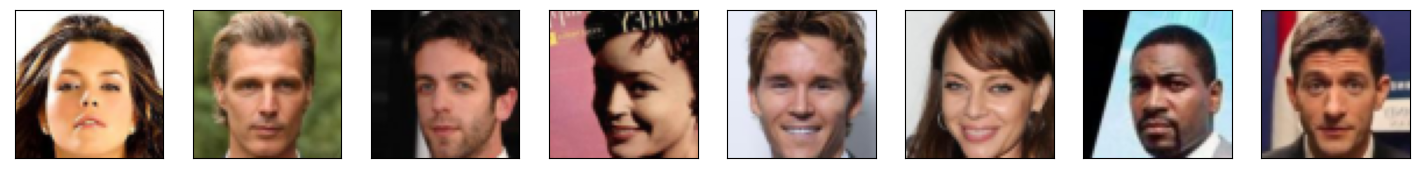

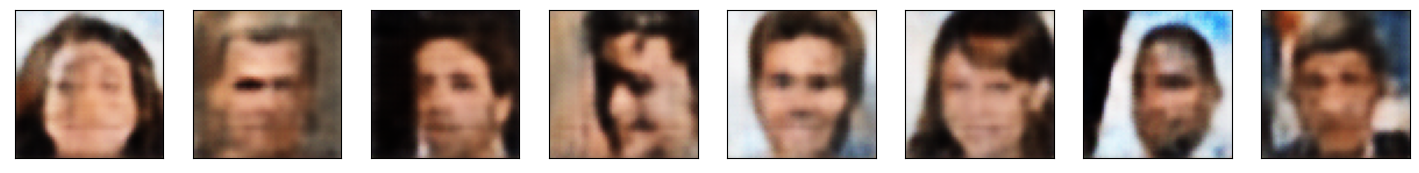

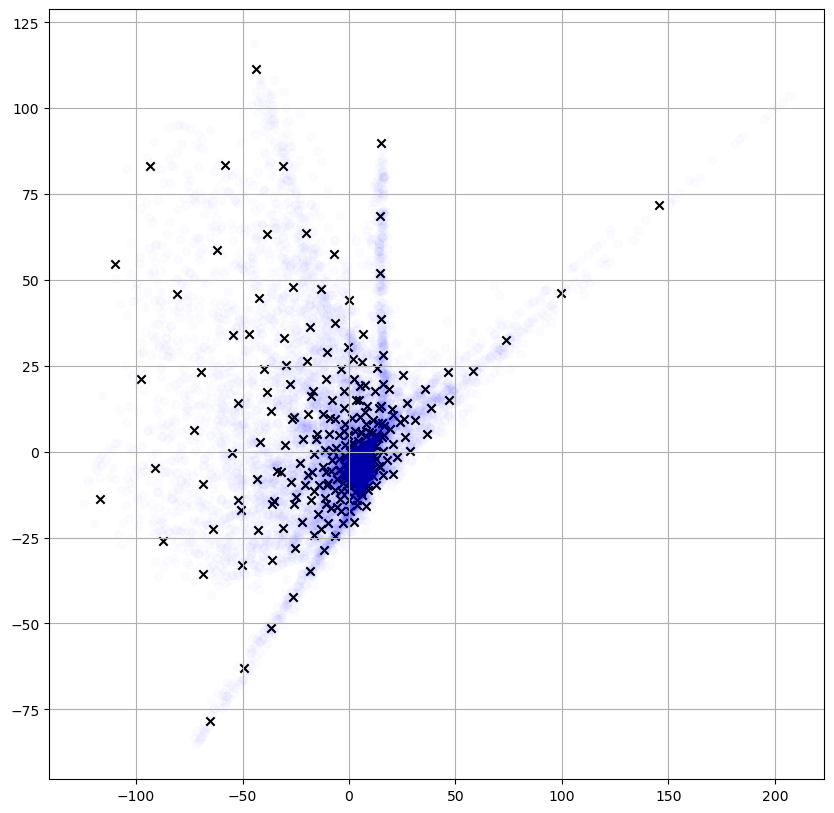

7001
lse_loss 524.3899536132812
commit_loss 0.18395590782165527
recon_loss 0.008054548874497414
7002
lse_loss 773.363037109375
commit_loss 0.2464863806962967
recon_loss 0.009046933613717556
7003
lse_loss 451.5400695800781
commit_loss 0.1884884536266327
recon_loss 0.008019747212529182
7004
lse_loss 521.6602172851562
commit_loss 0.23121654987335205
recon_loss 0.008637707680463791
7005
lse_loss 553.6757202148438
commit_loss 0.1845206916332245
recon_loss 0.008774854242801666
7006
lse_loss 544.6021728515625
commit_loss 0.1734430491924286
recon_loss 0.009130273014307022
7007
lse_loss 663.8324584960938
commit_loss 0.19034099578857422
recon_loss 0.009001282975077629
7008
lse_loss 660.8055419921875
commit_loss 0.19053849577903748
recon_loss 0.008363033644855022
7009
lse_loss 418.4826965332031
commit_loss 0.18178434669971466
recon_loss 0.008844012394547462
7010
lse_loss 734.9885864257812
commit_loss 0.1914418339729309
recon_loss 0.008425856940448284
7011
lse_loss 399.8153076171875
commit_loss 0.

7089
lse_loss 716.4380493164062
commit_loss 0.2249811291694641
recon_loss 0.008583331480622292
7090
lse_loss 404.8069763183594
commit_loss 0.2415996640920639
recon_loss 0.009153671562671661
7091
lse_loss 685.6932373046875
commit_loss 0.19623053073883057
recon_loss 0.009380463510751724
7092
lse_loss 459.0421447753906
commit_loss 0.2132921814918518
recon_loss 0.009475179016590118
7093
lse_loss 411.20379638671875
commit_loss 0.22800952196121216
recon_loss 0.008673150092363358
7094
lse_loss 528.6038208007812
commit_loss 0.21400031447410583
recon_loss 0.009042631834745407
7095
lse_loss 502.7179870605469
commit_loss 0.3130319118499756
recon_loss 0.0093041080981493
7096
lse_loss 525.4579467773438
commit_loss 0.20136740803718567
recon_loss 0.009771106764674187
7097
lse_loss 492.0137634277344
commit_loss 0.2557636797428131
recon_loss 0.00978771597146988
7098
lse_loss 558.9042358398438
commit_loss 0.23753929138183594
recon_loss 0.008487408049404621
7099
lse_loss 508.5091247558594
commit_loss 0.2

lse_loss 625.5831909179688
commit_loss 0.21237455308437347
recon_loss 0.009451720863580704
7177
lse_loss 768.3140869140625
commit_loss 0.25366729497909546
recon_loss 0.009375851601362228
7178
lse_loss 423.6776428222656
commit_loss 0.2270147204399109
recon_loss 0.008790138177573681
7179
lse_loss 566.4258422851562
commit_loss 0.2343694269657135
recon_loss 0.009818822145462036
7180
lse_loss 508.4876708984375
commit_loss 0.3129277229309082
recon_loss 0.009559372439980507
7181
lse_loss 576.2926635742188
commit_loss 0.2247459590435028
recon_loss 0.008931459859013557
7182
lse_loss 501.4698791503906
commit_loss 0.22565686702728271
recon_loss 0.008583354763686657
7183
lse_loss 585.6405639648438
commit_loss 0.19346170127391815
recon_loss 0.009546241723001003
7184
lse_loss 591.5392456054688
commit_loss 0.1993156522512436
recon_loss 0.009302194230258465
7185
lse_loss 701.1072387695312
commit_loss 0.2820974886417389
recon_loss 0.008454453200101852
7186
lse_loss 456.3948669433594
commit_loss 0.31248

7264
lse_loss 816.1234741210938
commit_loss 0.18657046556472778
recon_loss 0.009414365515112877
7265
lse_loss 1312.5074462890625
commit_loss 0.20473073422908783
recon_loss 0.009225165471434593
7266
lse_loss 359.1072082519531
commit_loss 0.18777307868003845
recon_loss 0.009049441665410995
7267
lse_loss 437.72998046875
commit_loss 0.18601727485656738
recon_loss 0.008500296622514725
7268
lse_loss 520.263427734375
commit_loss 0.19652530550956726
recon_loss 0.007990176789462566
7269
lse_loss 468.0960388183594
commit_loss 0.20177093148231506
recon_loss 0.008134564384818077
7270
lse_loss 547.1044311523438
commit_loss 0.2480260133743286
recon_loss 0.009272588416934013
7271
lse_loss 995.4744262695312
commit_loss 0.2632565498352051
recon_loss 0.009139103814959526
7272
lse_loss 620.0913696289062
commit_loss 0.19397875666618347
recon_loss 0.009142162278294563
7273
lse_loss 613.4696044921875
commit_loss 0.21123257279396057
recon_loss 0.00790146179497242
7274
lse_loss 950.0665893554688
commit_loss 0

7352
lse_loss 551.5368041992188
commit_loss 0.19906306266784668
recon_loss 0.008568709716200829
7353
lse_loss 449.5736389160156
commit_loss 0.2383301556110382
recon_loss 0.008547024801373482
7354
lse_loss 388.8504333496094
commit_loss 0.2030576765537262
recon_loss 0.008268273435533047
7355
lse_loss 439.9675598144531
commit_loss 0.1999456286430359
recon_loss 0.00830458477139473
7356
lse_loss 487.2337646484375
commit_loss 0.20784656703472137
recon_loss 0.008947251364588737
7357
lse_loss 446.6603088378906
commit_loss 0.22989904880523682
recon_loss 0.00860392302274704
7358
lse_loss 309.9712219238281
commit_loss 0.18851642310619354
recon_loss 0.008673235774040222
7359
lse_loss 433.0885314941406
commit_loss 0.1848207414150238
recon_loss 0.008677348494529724
7360
lse_loss 445.5670166015625
commit_loss 0.18276667594909668
recon_loss 0.008398826234042645
7361
lse_loss 385.3672790527344
commit_loss 0.19601769745349884
recon_loss 0.009043937548995018
7362
lse_loss 735.1117553710938
commit_loss 0.

lse_loss 567.287109375
commit_loss 0.21644556522369385
recon_loss 0.008528078906238079
7440
lse_loss 433.80682373046875
commit_loss 0.22826886177062988
recon_loss 0.010311475023627281
7441
lse_loss 458.0641174316406
commit_loss 0.2989398241043091
recon_loss 0.009159766137599945
7442
lse_loss 591.7782592773438
commit_loss 0.23422357439994812
recon_loss 0.008999822661280632
7443
lse_loss 542.1298217773438
commit_loss 0.3915289044380188
recon_loss 0.008325804024934769
7444
lse_loss 626.9990234375
commit_loss 0.20082131028175354
recon_loss 0.008180580101907253
7445
lse_loss 862.9439086914062
commit_loss 0.3122791647911072
recon_loss 0.008645306341350079
7446
lse_loss 687.7457885742188
commit_loss 0.24802732467651367
recon_loss 0.009592704474925995
7447
lse_loss 381.2930603027344
commit_loss 0.23401767015457153
recon_loss 0.008331390097737312
7448
lse_loss 596.0703735351562
commit_loss 0.2000826895236969
recon_loss 0.00873229093849659
7449
lse_loss 418.7920227050781
commit_loss 0.2289181351

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')